Classification of Handwritten digits of MNIST dataset

In [21]:
# General imports
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


# Create solution folder
Path("solution/").mkdir(exist_ok=True)

All individual operations, including activation functions, will be represented as layers in this model.
The abstract `Layer` interface defines three methods:

In [22]:
class Layer:
    def forward(self, x):
        """Forward pass of the layer.
        For convenience, input and output are stored in the layer. 

        Args:
            x: Input for this layer. Shape is (batch_size, num_inputs).

        Returns:
            x: Output of this layer. Shape is (batch_size, num_outputs).
        """
        raise NotImplementedError

    def backward(self, gradient):
        """Backward pass of the layer.
        The incoming gradients are stored in the layer. 

        Args:
            gradient: Incoming gradient from the next layer. Shape is (batch_size, num_outputs).

        Returns:
            gradient: Gradient passed to previous layer. Shape is (batch_size, num_inputs).
        """
        raise NotImplementedError

    def update(self, learn_rate):
        """Perform weight update based on previously stored input and gradients.

        Args:
            learn_rate: Learn rate to use for the update.
        """

In [23]:
class LinearLayer(Layer):
    def __init__(self, input_dim, output_dim, seed=None):
        """Initialize the layer with random weights."""
        # Initialize weights with the He initializer
        rnd = np.random.RandomState(seed).randn(input_dim, output_dim)
        self.w = rnd * (2 / input_dim) 
        
        # Initialize bias with zeros
        self.b = np.zeros(output_dim)
        
    def forward(self, x):
        """Forward pass of the layer."""
        x = np.array(x)
        self.input = x # Store input
    
        x = x.dot(self.w) + self.b
        
        self.output = x # Store output
        return x
    
    def backward(self, gradient):
        """Backward pass of the layer."""
        gradient = np.array(gradient)
        self.gradient = gradient # Store incoming gradient
      
        gradient = gradient.dot(self.w.T)
        
        return gradient
    
    def update(self, learn_rate):
        """Perform weight update"""
        self.w = self.w - learn_rate * self.gradient.T.dot(self.input).T
        self.b = self.b - learn_rate * np.sum(self.gradient, axis=0).reshape(-1)

In [24]:
# Test code
_test_layer = LinearLayer(4, 5, seed=42)

# Test forward pass
np.testing.assert_array_almost_equal(_test_layer.forward(np.ones((1, 4))), [[-0.38156401, -0.01880618,  0.98566644, -0.88387442, -1.41440743]])

# Test backward pass
np.testing.assert_array_almost_equal(_test_layer.backward(np.ones((1, 5))), [[1.147507,  1.092798, -2.162692, -1.7906 ]])

# Test update
_test_layer.update(0.1)
np.testing.assert_array_almost_equal(_test_layer.w, [[ 0.148357, -0.169132,  0.223844,  0.661515, -0.217077], [-0.217068,  0.689606,  0.283717, -0.334737,  0.17128 ], [-0.331709, -0.332865,  0.020981, -1.05664 , -0.962459], [-0.381144, -0.606416,  0.057124, -0.554012, -0.806152]])
np.testing.assert_array_almost_equal(_test_layer.b, [-0.1, -0.1, -0.1, -0.1, -0.1])
"ok"

'ok'

In [25]:
class ReLULayer(Layer):      
    def forward(self, x):
        """Forward pass of the ReLU layer."""
        x = np.array(x)
        self.input = x # Store input
        
        x[x <= 0] = 0
     
        self.output = x # Store output
        return x
    
    def backward(self, gradient):
        """Backward pass of the ReLU layer."""
        gradient = np.array(gradient)
        self.gradient = gradient # Store incoming gradient
     
        self.gradient[self.input <= 0] = 0
        gradient = self.gradient
     
        return gradient

In [26]:
# Test Code
_test_layer = ReLULayer()

# Test forward pass
np.testing.assert_array_almost_equal(_test_layer.forward(np.arange(5)-2), [0, 0,  0, 1, 2])

# Test backward pass
assert np.array_equal(_test_layer.backward(np.ones(5)), [0, 0, 0, 1, 1]) or np.array_equal(_test_layer.backward(np.ones(5)), [0, 0, 1, 1, 1]), f"backward expected {[0, 0, 1, 1, 1]} or {[0, 0, 0, 1, 1]}, but got {_test_layer.backward(np.ones(5))}"

"ok"

'ok'

In [27]:
class SoftmaxLayer(Layer):      
    def forward(self, x):
        """Forward pass of the softmax layer."""
        x = np.array(x)   
        
        if len(x.shape) == 1:
            x = x.reshape(1, -1)
            self.input = x # Store input
            a = np.exp(x - np.max(x))
            b = np.sum(a, axis=1).reshape(-1, 1)
            x = a / b
            
            self.output = x # Store output
            return x.reshape(-1)
        else:
            self.input = x # Store input
            a = np.exp(x - np.max(x))
            b = np.sum(a, axis=1).reshape(self.input.shape[0], 1)
            x = a / b

            self.output = x # Store output
            return x

In [28]:
# Test code
_test_layer = SoftmaxLayer()

# Test forward pass
np.testing.assert_array_almost_equal(_test_layer.forward([[1, 1]]), [[0.5, 0.5]])
np.testing.assert_array_almost_equal(_test_layer.forward([1, 2, 3]), [0.09003057, 0.24472847, 0.66524096])
np.testing.assert_array_almost_equal(_test_layer.forward([0, 1, 2]), [0.09003057, 0.24472847, 0.66524096])
np.testing.assert_array_almost_equal(_test_layer.forward([0]), [1])
np.testing.assert_array_almost_equal(_test_layer.forward([0, 10, 100, 1e6]), [0, 0, 0, 1], err_msg="Overflow")

"ok"

'ok'

Completing the Network

In [29]:
class FeedForwardNet:
    def __init__(self, layers):
        self.layers = layers
    
    def forward(self, x):
        """Forward pass through the entire network."""
      
        for layer in self.layers: 
            x = layer.forward(x)
        
        return x
    
    def backward(self, gradient):
        """Backward pass through the entire network."""

        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
  

    def train(self, x, target, learn_rate):
        """Train one batch."""
        target = np.array(target)
        gradient = self.forward(x) - target  # Assumes quadratic loss function
        self.backward(gradient)  # Backprop
        
        # Update weights in all layers
        for layer in self.layers:
            layer.update(learn_rate)

In [30]:
# Test Code
_test_net = FeedForwardNet([LinearLayer(4, 10, seed=0),
                      ReLULayer(),
                      LinearLayer(10, 3, seed=1),
                      SoftmaxLayer(),
                     ])
np.testing.assert_array_almost_equal(_test_net.forward([1,2,3,4]), [0.27760362, 0.64002456, 0.08237182])
"ok"

'ok'

Autoencoder on MNIST Dataset

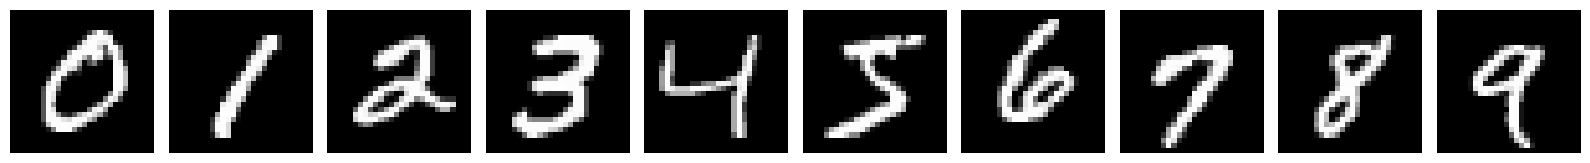

In [31]:
import torch
import torchvision
from torchvision import transforms

# Load MNIST dataset
mnist = torchvision.datasets.MNIST(root='data/', download=True, transform=transforms.ToTensor())
mnist_test = np.array([x.numpy() for x, y in torchvision.datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor())]).reshape(-1, 28, 28)
data_loader = torch.utils.data.DataLoader(mnist, batch_size=32, shuffle=True)

# Show examples
plt.figure(figsize=(16,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    
    # Choose first example with the corresponding digit
    example = next(x for x, y in mnist if y == i).reshape(28, 28)
    plt.imshow(example, cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
plt.tight_layout()

In [32]:
autoencoder = FeedForwardNet([LinearLayer(784, 256, seed=0),
                              ReLULayer(),
                              LinearLayer(256, 128, seed=1),
                              ReLULayer(),
                              LinearLayer(128, 16, seed=2),
                              LinearLayer(16, 128, seed=3),
                              ReLULayer(),
                              LinearLayer(128, 256, seed=4),
                              ReLULayer(),
                              LinearLayer(256, 784, seed=5)
                              ])

In [33]:
# Test Code
assert all(type(l) in [LinearLayer, ReLULayer] for l in autoencoder.layers), "Only use Linear and ReLu layers"
assert autoencoder.layers[0].w.shape[0] == 784, "Wrong size of input"
assert autoencoder.layers[-1].w.shape[1] == 784, "Wrong size of output"
assert min(l.w.shape[0] for l in autoencoder.layers if type(l) == LinearLayer) == 16, "Wrong size of the bottleneck"

"ok"

'ok'

Implement the training of a batch.

The incoming batches of images have a shape of (batch_size, 28, 28). To process them in a linear layer, they are reshaped to (batch_size, 28 * 28).

Then, the `train` method of the implemented `FeedForwardNetwork` is used to train the batch.

  0%|          | 0/10 [00:00<?, ?it/s]

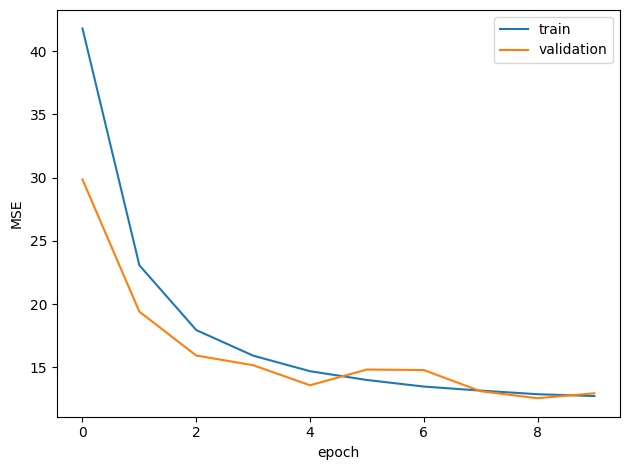

In [34]:
#Train the Autoencoder
epochs = 10

losses = np.empty((epochs, 2))
with tqdm(range(epochs)) as pbar:
    for epoch in pbar:
        running_loss = 0.0
        for batch, _ in data_loader:
            batch = batch.reshape(batch.shape[0], -1)
            autoencoder.train(batch, batch, 0.002)

            running_loss += np.sum((autoencoder.layers[-1].output - np.array(batch))**2)
        
        # Log losses and update progress bar
        train_loss = running_loss/len(mnist)
        validation_loss = np.sum(np.mean((autoencoder.forward(mnist_test.reshape(-1, 28*28))-mnist_test.reshape(-1, 28*28))**2, axis=0))
        losses[epoch] = [train_loss, validation_loss]
        pbar.set_description(f"Loss {train_loss:.02f}/{validation_loss:.02f}")
        if validation_loss < 11:
            break

# Save model
with open("solution/a2b.pickle", "wb") as f:
    pickle.dump(autoencoder, f)

# Visualize losses
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses[:,0], label="train")
plt.plot(np.arange(len(losses)), losses[:,1], label="validation")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.tight_layout()
plt.savefig("solution/a2b-train.png")

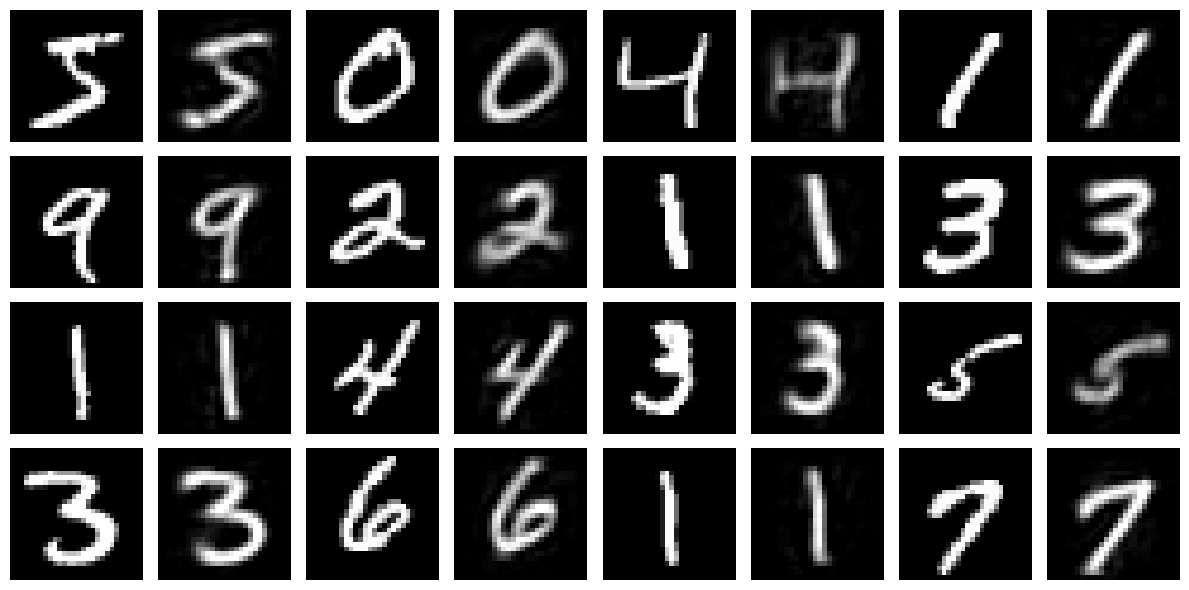

In [35]:
# Show reconstruction
plt.figure(figsize=(12,6))
for i in range(16):
    # Show image
    plt.subplot(4,8,2*i+1)
    plt.imshow(mnist[i][0].reshape((28,28)), cmap="gray")
    plt.axis("off")

    # Show reconstruction
    plt.subplot(4,8, 2*i+2)
    plt.imshow(autoencoder.forward(mnist[i][0].reshape(28*28)).reshape(28,28), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
plt.tight_layout()
plt.savefig("solution/a2b-rec.png")